# A-Feature Analysis
This is an optional notebook where we will go through the steps of creating random walks using the A-path method. These can be used as a feature when learning HAS-embeddings in the HAS_entity_embeddings notebook. We will consider different implementation decisions and look at the results of using this feature for learning embeddings.

*What is this feature?* --> These random walks are intended to detect attributive similarity. I.e. entities with similar attribute values are similar.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [27]:
import os
import math
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

## parameters

**Embedding model parameters**   
*type_to_profile*: Q-node denoting the type of entities you want to create embeddings for (potentially do this for all types in the dataset and get rid of this parameter)
*num_walks*: Number of random walks to start at each node with the A-feature walk method   
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*label_file*: File path for the file that contains wikidata labels.  
*work_dir*: same work_dir that you specified in the label creation notebook. We'll look for files created by that notebook here. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [3]:
# Embedding model params
type_to_profile = "Q5"
num_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
data_dir = "./data/wikidata_humans"
label_file = "{}/labels.en.tsv.gz".format(data_dir)
work_dir = "./output/wikidata_humans_v3"
store_dir = "./output/wikidata_humans_v3/temp"

### Process parameters and set up variables / file names

In [4]:
# Ensure paths are absolute
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/A_walks_analysis_4".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(store_dir):
    os.makedirs(store_dir)
    
walks_file = "{}/a_walks.txt".format(output_dir)

# Setting up environment variables 
os.environ["TYPE"] = type_to_profile
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

### 1. Create mapping of {entity : other entities that can be hopped to}

In [12]:
# given values that all correspond to the same label kind,
# return corresponding intervals based on percentile
def get_bin_nums_for_values_based_on_percentile(values, num_bins):
    values = np.array(values)
    indexes = np.arange(len(values))
    
    # sort values and corresponding labels in ascending order
    indexes = np.array([i for i, v in sorted(zip(indexes, values), key=lambda pair: pair[1])])
    values.sort()
    
    interval_bounds = []
    for i in range(num_bins):
        index_of_ubound = math.ceil(((i+1)/num_bins)*len(values)) - 1
        ubound = values[index_of_ubound]
        if len(interval_bounds)==0 or ubound != interval_bounds[-1]:
            interval_bounds.append(ubound)
    bin_nums_for_values=[]
    cur_bin_num=0
    for i in range(len(values)):
        while values[i] > interval_bounds[cur_bin_num]:
            cur_bin_num += 1
        bin_nums_for_values.append(cur_bin_num)
    
    # rearrange bin nums to original order of values
    bin_nums_for_values_unscrambled = np.zeros(len(bin_nums_for_values), dtype=int)
    for i in range(len(indexes)):
        bin_nums_for_values_unscrambled[indexes[i]] = bin_nums_for_values[i]
        
    return bin_nums_for_values_unscrambled
    
    
# Given a file containing numeric valued attribute labels,
# create a [[{entities in bin} for bin in however many bins we are making] for attribute in file]
def get_buckets_for_attributes_by_percentile(df, num_bins):
        
    if "bin_num" not in df.columns:
        df.insert(loc = len(df.columns), column = "bin_num", value = ["" for i in range(df.shape[0])])

    # get distinct label types (defined by type and property, as well as si and wd units if we have them)
    if "si_units" in df.columns and "wd_units" in df.columns:
        distinct_labels = df.loc[:, ["node1", "label", "property_label", "si_units", "wd_units"]].drop_duplicates()
    else:
        distinct_labels = df.loc[:, ["node1", "label", "property_label"]].drop_duplicates()
    
    attribute_bins = {}
    # Could probably be improved with a list comprehension
    for index, row in distinct_labels.iterrows():
        # Get subset of labels that match this distinct kind of label
        subset_mask = (df["node1"] == row["node1"]) & (df["label"] == row["label"])
        # if we have units, treat these as part of the kind of label
        if "si_units" in df.columns and "wd_units" in df.columns:
            subset_mask = subset_mask & (df["si_units"] == row["si_units"]) & (df["wd_units"] == row["wd_units"])
        subset = df.loc[subset_mask]
        
        # Shouldn't happen, just checking.
        values = subset.loc[:,"node2"]
        if(len(values) == 0):
            print("no values found for subset:\n{}\n".format(subset))
            print("row:\n{}\n".format(row))
        
        bins_for_values = get_bin_nums_for_values_based_on_percentile(values, num_bins)
        
        df.loc[subset_mask,"bin_num"] = bins_for_values
        bins_to_ents = df.loc[subset_mask].groupby(by=["bin_num"])["entity"].apply(list).to_dict()
        attr_name = row["property_label"]
        if "si_units" in df.columns and "wd_units" in df.columns:
            if row["si_units"]:
                attr_name = "{}_{}".format(attr_name, row["si_units"])
            elif row["wd_units"]:
                attr_name = "{}_{}".format(attr_name, row["wd_units"])
        attribute_bins[attr_name] = [bins_to_ents[i] for i in range(len(bins_to_ents.keys()))]

    return attribute_bins

In [13]:
avl_file = "{}/label_creation/entity_AVLs_all.tsv".format(work_dir)
df = pd.read_csv(avl_file, delimiter='\t')

#remove this when making this work for all types in graph
df = df.loc[df.loc[:,"node1"]=="Q5",:]

# blank values in units columns are expected as not all values will have units.
# we want blank units to compare equal to eachother, so fill NaN's in as "" in units columns.
if "si_units" in df.columns and "wd_units" in df.columns:
    df.fillna("", inplace = True)

# we also don't want to consider any string type values
types = [type(v) for v in df.loc[:,"node2"]]
non_str_mask = [True if (t != str) else False for t in types]
df = df.loc[non_str_mask]
    
attribute_bins = get_buckets_for_attributes_by_percentile(df, num_bins=100)

/nas/home/nmklein/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
with open("{}/attribute_bins.json".format(output_dir), 'w') as f:
    json.dump(attribute_bins, f)

In [5]:
with open("{}/attribute_bins.json".format(output_dir), 'r') as f:
    attribute_bins = json.load(f)

with open("{}/attribute_bins.json".format(output_dir), 'r') as f:
    attribute_bins = json.load(f)

In [17]:
len(attribute_bins)

170

Create attribute combination bins

In [6]:
%%time
ent_to_comb_bins = dict()
for attr_idx in attribute_bins.keys():
    bins = attribute_bins[attr_idx]
    for bin_idx in range(len(bins)):
        for ent in attribute_bins[attr_idx][bin_idx]:
            if ent not in ent_to_comb_bins:
                ent_to_comb_bins[ent] = dict()
            ent_to_comb_bins[ent][attr_idx] = bin_idx
            
ent_to_comb_str = {ent : json.dumps(attr_bin_dict, sort_keys=True) for ent, attr_bin_dict in ent_to_comb_bins.items()}

comb_bins_to_ents = dict()      
for ent, attr_bin_dict in ent_to_comb_bins.items():
    comb_str = json.dumps(attr_bin_dict, sort_keys=True)
    if comb_str not in comb_bins_to_ents:
        comb_bins_to_ents[comb_str] = []
    comb_bins_to_ents[comb_str].append(ent)
    
comb_bin_neighbors = {}
for comb_str in tqdm(comb_bins_to_ents.keys()):
    comb_bin_neighbors[comb_str] = []
    comb_bin = json.loads(comb_str)
    # neighboring bins
    for attr_idx in comb_bin.keys():
        comb_bin[attr_idx] += 1
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] -= 2
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] += 1
    # combinations that have additional attributes
    neighbor_comb_strs = list(comb_bins_to_ents.keys())
    neighbor_comb_strs.remove(comb_str)
    for attr_bin_str in comb_str[1:-1].split(", "):
        neighbor_comb_strs = [d for d in neighbor_comb_strs if attr_bin_str in d]
        if len(neighbor_comb_strs) == 0:
            break
    
    comb_bin_neighbors[comb_str].extend(neighbor_comb_strs)

CPU times: user 41.6 s, sys: 1.67 s, total: 43.3 s
Wall time: 43.3 s


In [22]:
comb_bin_neighbors = {}
for comb_str in tqdm(comb_bins_to_ents.keys()):
    comb_bin_neighbors[comb_str] = []
    comb_bin = json.loads(comb_str)
    # neighboring bins
    for attr_idx in comb_bin.keys():
        comb_bin[attr_idx] += 1
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] -= 2
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] += 1
    # combinations that have additional attributes
    neighbor_comb_strs = list(comb_bins_to_ents.keys())
    neighbor_comb_strs.remove(comb_str)
    for attr_bin_str in comb_str[1:-1].split(", "):
        neighbor_comb_strs = [d for d in neighbor_comb_strs if attr_bin_str in d]
        if len(neighbor_comb_strs) == 0:
            break
    
    comb_bin_neighbors[comb_str].extend(neighbor_comb_strs)

In [25]:
with open("{}/comb_bin_neighbors.json".format(output_dir), 'w') as f:
    json.dump(comb_bin_neighbors, f)

In [7]:
with open("{}/comb_bin_neighbors.json".format(output_dir), 'r') as f:
    comb_bin_neighbors = json.load(f)

In [17]:
list(comb_bins_to_ents.keys())[0]

'{"\'date of birth\'@en": 0, "\'date of death\'@en": 1}'

In [24]:
comb_bin_neighbors[ent_to_comb_str[list(comb_bins_to_ents.values())[0][0]]]

['{"\'date of birth\'@en": 1, "\'date of death\'@en": 1}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 2}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 0}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'floruit\'@en": 14}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'work period (start)\'@en": 0}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'number of children\'@en": 5}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 12}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'number of children\'@en": 7}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'floruit\'@en": 13}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'work period (end)\'@en": 0, "\'work period (start)\'@en": 0}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'number of children\'@en": 0}',
 '{"\'date of birth\'@en": 0, "\'date of death\'@en": 1, "\'floruit\'@en": 15, "\'work period (end)\'@en": 1, "\'

Number of distinct attribute-bin combinations:

In [12]:
len(comb_bins_to_ents.keys())

154934

### 3. Perform the random walks

In [32]:
ent_to_comb_str["Q7747"]

'{"P2031": 29, "P2048_Q174728": 14, "P2067_Q11570": 26, "P2218_Q41044": 0, "P569": 60}'

In [48]:
def random_walks_to_file(ent_to_comb_str, comb_bins_to_ents, walks_file, walk_length=10, num_walks=10):
    entities = ent_to_comb_str.keys()
    print("num entities to perform walks from: {}".format(len(entities)))
    with open(walks_file, "w") as f:
        for ent in tqdm(entities):
            for i in range(num_walks):
                walk = random_walk_from_node(ent_to_comb_str, comb_bins_to_ents, ent, walk_length)
                f.write("{}\n".format(walk))


# Returns a string of space separated Q-nodes as a walk
def random_walk_from_node(ent_to_comb_str, comb_bins_to_ents, start_ent, walk_length):
    walk = start_ent
    cur_ent = start_ent
    cur_length = 1
    while cur_length < walk_length:
        # get ents in same bin
        cur_bin = ent_to_comb_str[cur_ent]
        neighbor_bins = comb_bin_neighbors[cur_bin]
        if len(comb_bins_to_ents[cur_bin]) == 1:
            if len(neighbor_bins) == 0:
                break
            ents = comb_bins_to_ents[random.choice(neighbor_bins)]
            next_ent = random.choice(ents)
        else:
            bin_choice = random.randint(0,len(neighbor_bins))
            if bin_choice < len(neighbor_bins):
                ents = comb_bins_to_ents[neighbor_bins[bin_choice]]
                next_ent = random.choice(ents)
            else:
                ents = comb_bins_to_ents[cur_bin]
                ent_choice = random.randint(0,len(ents)-1)
                if ents[ent_choice] == cur_ent:
                    ent_choice = (ent_choice + random.randint(0,len(ents)-2)) % len(ents)
                next_ent = ents[ent_choice]
        walk = "{} {}".format(walk, next_ent)
        cur_ent = next_ent
        cur_length += 1
    return walk

In [49]:
%%time
random_walks_to_file(ent_to_comb_str, comb_bins_to_ents, walks_file, walk_length, num_walks)

  0%|          | 510/4421413 [00:00<14:27, 5096.93it/s]

num entities to perform walks from: 4421413


  4%|▍         | 195951/4421413 [00:59<21:13, 3316.91it/s]


KeyboardInterrupt: 

In [50]:
%%time
random_walks_to_file(ent_to_comb_str, comb_bins_to_ents, walks_file, walk_length, num_walks)

num entities to perform walks from: 4421413



CPU times: user 27min 5s, sys: 22 s, total: 27min 27s
Wall time: 27min 11s


### 4. Let's see what embeddings we learn if we only use this feature
Use Skip-Gram model to learn representations for the entities

In [55]:
%%time
model = Word2Vec(corpus_file=walks_file, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/A_embeddings.kv".format(output_dir))

CPU times: user 1d 12h 21min 51s, sys: 9min 18s, total: 1d 12h 31min 9s
Wall time: 1h 34min 1s


In [24]:
ent_to_comb_bins["Q7747"]

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [25]:
comb_bins_to_ents[ent_to_comb_str["Q7747"]]

['Q7747']

In [26]:
ent_to_comb_bins["Q3760617"]

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14}

In [43]:
ent_to_comb_bins["Q6171026"]

{"'date of birth'@en": 60,
 "'mass'@en_Q100995": 12,
 "'number of matches played/races/starts'@en": 50,
 "'total goals in career'@en": 19,
 "'total shots in career'@en": 53,
 "'total points in career'@en": 37,
 "'total assists in career'@en": 35,
 "'penalty minutes in career'@en": 21,
 "'career plus-minus rating'@en": 11}

In [63]:
comb_bins_to_ents[ent_to_comb_str["Q3760617"]]

['Q3760617']

In [65]:
model.wv.most_similar(positive=["Q7747"], topn=100)

[('Q3760617', 0.865553617477417),
 ('Q6767982', 0.8348532319068909),
 ('Q6490382', 0.8342655897140503),
 ('Q922940', 0.8337225914001465),
 ('Q3499105', 0.8326786756515503),
 ('Q925063', 0.8325059413909912),
 ('Q5220408', 0.83198082447052),
 ('Q366559', 0.8299462795257568),
 ('Q7228954', 0.8287657499313354),
 ('Q1335828', 0.8276548385620117),
 ('Q214974', 0.8273299932479858),
 ('Q6221344', 0.8272722959518433),
 ('Q6378582', 0.8269789218902588),
 ('Q84063', 0.8266251683235168),
 ('Q3704269', 0.8262641429901123),
 ('Q6382035', 0.8243404030799866),
 ('Q3017161', 0.8243374824523926),
 ('Q728234', 0.8234039545059204),
 ('Q3313454', 0.8232148885726929),
 ('Q448872', 0.8222715854644775),
 ('Q553261', 0.8222671747207642),
 ('Q5334859', 0.822086751461029),
 ('Q733261', 0.8208723068237305),
 ('Q6382039', 0.8205651044845581),
 ('Q187198', 0.8196033239364624),
 ('Q7150107', 0.8188592791557312),
 ('Q7228923', 0.8188012838363647),
 ('Q3218035', 0.8186278939247131),
 ('Q1701997', 0.8186079859733582),


Robin williams (1951) to Putin (1952)

In [27]:
display(ent_to_comb_bins["Q83338"])
display(ent_to_comb_bins["Q7747"])

{"'date of birth'@en": 60,
 "'date of death'@en": 93,
 "'work period (start)'@en": 27,
 "'work period (end)'@en": 72,
 "'net worth'@en_Q4917": 28}

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [32]:
model.similarity("Q83338","Q7747")

0.6246197

Stevie Wonder (1950) to Putin (1952)

In [33]:
display(ent_to_comb_bins["Q714"])
display(ent_to_comb_bins["Q7747"])

{"'date of birth'@en": 59, "'work period (start)'@en": 20}

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [34]:
model.similarity("Q714","Q7747")

0.5429982

Bruce Springsteen (1949) to Putin (1952)

In [35]:
display(ent_to_comb_bins["Q1225"])
display(ent_to_comb_bins["Q7747"])

{"'date of birth'@en": 59,
 "'work period (start)'@en": 25,
 "'height'@en_Q11573": 24}

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [36]:
model.similarity("Q1225","Q7747")

0.6413831

Steve Jobs (1955) to Putin (1952)

In [37]:
display(ent_to_comb_bins["Q19837"])
display(ent_to_comb_bins["Q7747"])

{"'date of birth'@en": 63, "'date of death'@en": 90}

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [38]:
model.similarity("Q19837","Q7747")

0.18387155

Bill Gates (1955) to Putin (1952)

In [39]:
display(ent_to_comb_bins["Q5284"])
display(ent_to_comb_bins["Q7747"])

{"'date of birth'@en": 63,
 "'work period (start)'@en": 29,
 "'number of children'@en": 3,
 "'height'@en_Q11573": 24,
 "'Erdős number'@en": 3}

{"'date of birth'@en": 60,
 "'work period (start)'@en": 29,
 "'height'@en_Q174728": 14,
 "'mass'@en_Q11570": 26,
 "'net worth'@en_Q41044": 0}

In [40]:
model.similarity("Q5284","Q7747")

0.3533253

We want similar entities to have more similar embeddings. This feature aims to capture a measure of attributive similarity amongst entities of the same type. Therefore we will compare entities within a type to evaluate the embeddings that are learned with this feature.

The below doesn't work because we didn't acount for an entity not having ANY numeric attributes... should account for this. Although if we don't, not clear makes a big difference to final embeddings as long as we use other features as well.

In [15]:
# beer_vecs = model.wv['Q12877510', 'Q61976614', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
# similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
# mask = np.zeros_like(similarity_mat)
# mask[np.triu_indices_from(mask)] = True
# labels = ['Macedonian Thrace Brewery', 'Rastrum', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# # Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
# fig, ax = plt.subplots(figsize=(9,7))
# sns.set(font_scale=1.5)
# sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
# plt.xticks(rotation=30, horizontalalignment='right')
# plt.title("Cosine similarity of beer embeddings")
# plt.show()

KeyError: "word 'Q61976614' not in vocabulary"

The beer called 'Rastrum' seems to be an outlier. Searching for it online gives few results related to beer. Looking at similarities without this beer so we can more easily see how the others compare

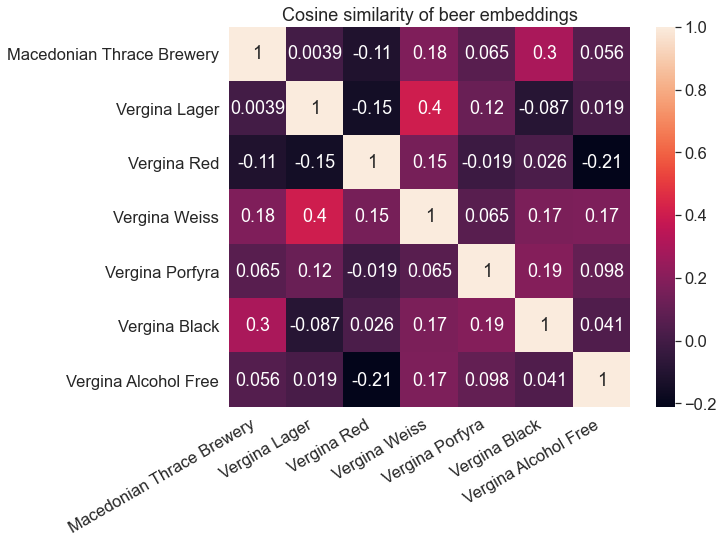

In [17]:
# beer_vecs = model.wv['Q12877510', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
# similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
# mask = np.zeros_like(similarity_mat)
# mask[np.triu_indices_from(mask)] = True
# labels = ['Macedonian Thrace Brewery', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# # Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
# fig, ax = plt.subplots(figsize=(9,7))
# sns.set(font_scale=1.5)
# sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
# plt.xticks(rotation=30, horizontalalignment='right')
# plt.title("Cosine similarity of beer embeddings")
# plt.show()